#### Making correlation plots and venn diagrams for our six slices

In [55]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm.notebook import tqdm
import itertools as it
import seaborn as sns
from scipy.stats import kde, pearsonr, spearmanr
import warnings
import pickle as pkl
from functools import reduce 
from venn import venn, get_labels

In [56]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [70]:
with open('/data/xyzeq/xyzeq/concatenated.deep/deep2/exps.pkl','rb') as file:
    exps = pkl.load(file)

Agreed to drop L20C and L30C8.

In [71]:
for exp in exps.keys():
    if (exps[exp]['label'] == 'L20C') or (exps[exp]['label'] == 'L30C8'):
        print(exp)
        continue

3
5


In [72]:
del(exps[3])
del(exps[5])

Still want a "3" in my `exps`.

In [73]:
exps[3] = exps[4]
del(exps[4])

In [74]:
for exp in exps:
    print(exps[exp]['adata'].shape)

(15277, 121472)
(22476, 121472)
(24972, 121472)
(6918, 121472)


In [75]:
exps[exp]['adata']

AnnData object with n_obs × n_vars = 6918 × 121472 
    obs: 'n_counts', 'organism'

In [63]:
for exp in exps:
    sc.pp.normalize_per_cell(exps[exp]['adata'], 
                             counts_per_cell_after=1e6)
#     sc.pp.log1p(exps[exp]['adata'])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [64]:
common_genes = reduce(np.intersect1d, [exps[exp]['adata'].var_names for exp in exps])

In [76]:
# Agreed upon nomenclature with Youjin
nomen_map = {'L10C':'Slice 1',
             'L20C1':'Slice 2',
             'L20T':'Slice 3',
             'L30C':'Slice 4',
            }

In [77]:
for exp in exps:
    exps[exp]['label'] = nomen_map[exps[exp]['label']]

In [ ]:
fig, axarr = plt.subplots(len(exps),len(exps),figsize=(20,20))

# I'm using the lower triangle of a square array, but what's nice is that the indices = 1 are also the indices (in exps) of the experiments I would like to compare
comps = np.argwhere(np.tri(len(exps),k=-1)) # comparisons 

for comp in tqdm(comps): 
    ax = axarr[comp[0],comp[1]]
    arr0 = np.array(exps[comp[0]]['adata'][:,common_genes].X.mean(0))[0]
    arr1 = np.array(exps[comp[1]]['adata'][:,common_genes].X.mean(0))[0]
    idxs = np.random.choice(range(len(arr0)), 10000, replace=False)
    ax.scatter(arr0[idxs], arr1[idxs], s=2, c='k');
    ax.set_ylim(-100, 1500)
    ax.set_xlim(-100, 1500)
    if comp[1] == 0:
        ax.set_ylabel(exps[comp[0]]['label'])
    else:
        ax.set_yticklabels([])
    if comp[0] == len(exps) - 1:
        ax.set_xlabel(exps[comp[1]]['label'])
    else:
        ax.set_xticklabels([])
    ax.grid(False)
    
    ax = axarr[comp[1], comp[0]]
    ax.text(0.5, 0.5, 'r=' + str(spearmanr(arr0,arr1)[0])[:5], size=20, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(False)
    ax.axis('off')
for i in tqdm(range(len(exps))):
    ax = axarr[i,i]
    ax.text(0.9, 0.9, exps[i]['label'], size=20, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
    arr = np.array(exps[i]['adata'][:,common_genes].X.mean(0))[0]
    arr = arr[arr < 1500]
    ax.hist(arr,bins=300, color='gray')
    if i != len(exps) -1:
        ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.grid(False)
    if i == 0:
        ax.set_ylabel(exps[i]['label'])
    if i == len(exps)-1:
        ax.set_xlabel(exps[i]['label'])
plt.savefig('/data/xyzeq/xyzeq/figures/xyzeq.correlations.pdf')
plt.savefig('/data/xyzeq/xyzeq/figures/xyzeq.correlations.svg')

For all genes with a raw count > 1

In [67]:
for exp in exps:
    exps[exp]['genes_detected'] = set(exps[exp]['adata'].var_names[np.array(exps[exp]['adata'].X.sum(0) > 0)[0]].values)

In [68]:
genes_detected_dict = dict(zip(map(lambda x: exps[x]['label'], exps.keys()),map(lambda x: exps[x]['genes_detected'], exps.keys())))

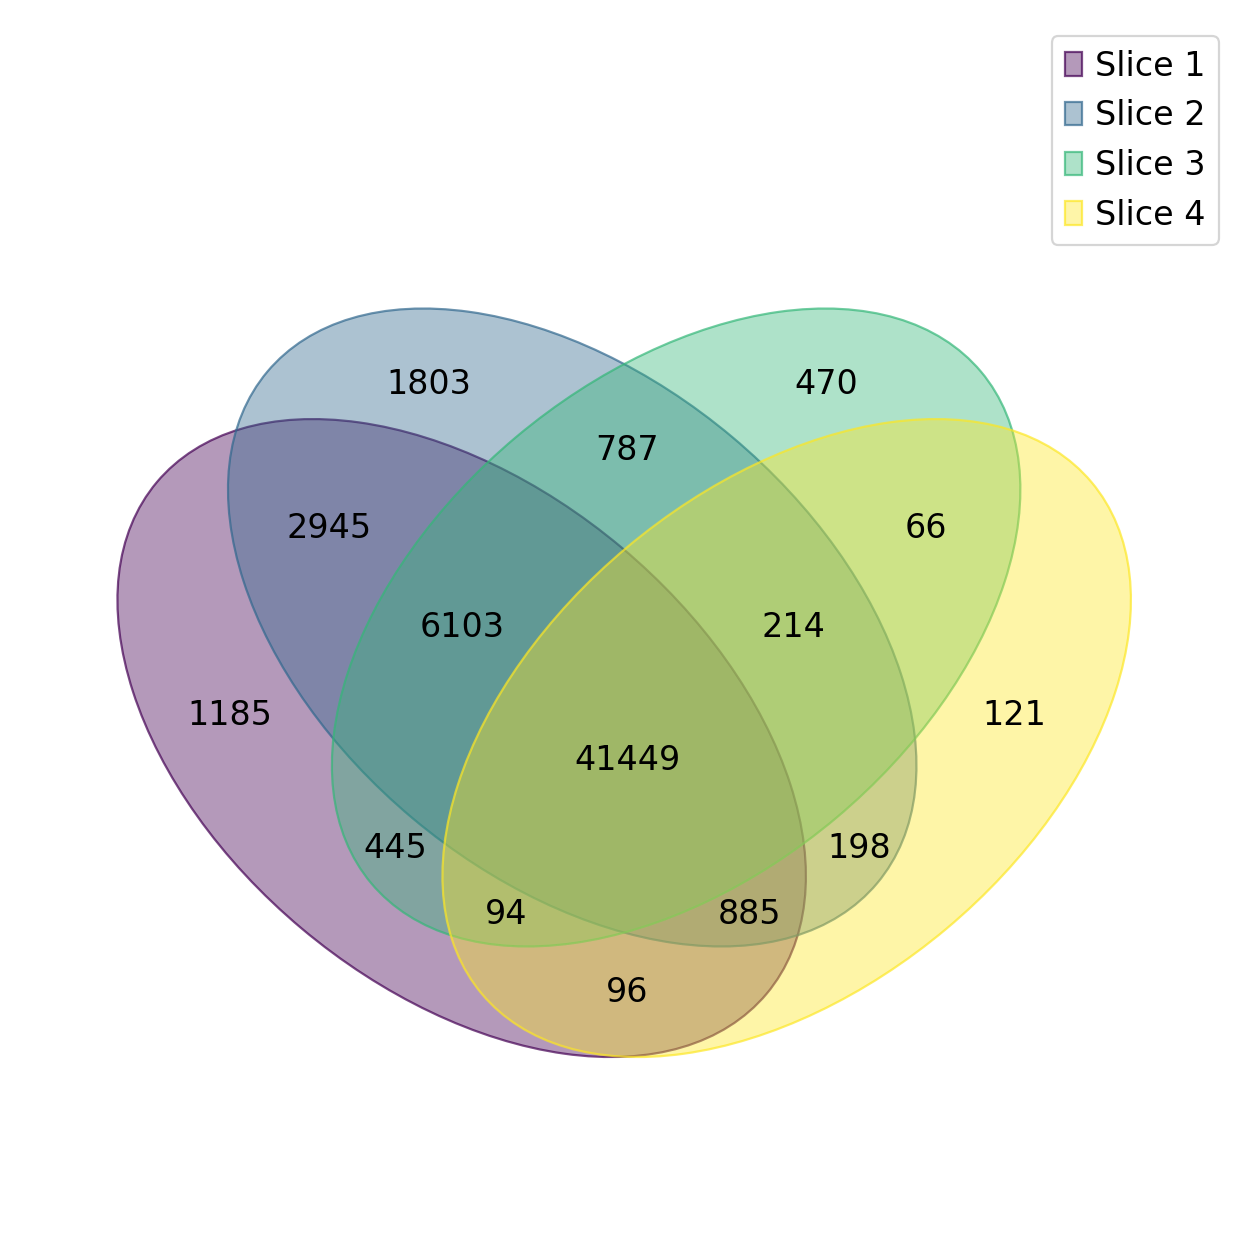

In [69]:
venn(genes_detected_dict, figsize=(10,10), fontsize=15);
# plt.savefig('/data/xyzeq/xyzeq/figures/xyzeq.venn.pdf')
# plt.savefig('/data/xyzeq/xyzeq/figures/xyzeq.venn.svg')

For top genes:

### RE-RUN THE FIRST FEW CELLS TO RELOAD THE DATA FRESH

In [78]:
for exp in exps:
    sc.pp.filter_cells(exps[exp]['adata'],min_counts=1)
    sc.pp.filter_genes(exps[exp]['adata'],min_counts=1)
    sc.pp.filter_cells(exps[exp]['adata'],min_genes=1)
    sc.pp.filter_genes(exps[exp]['adata'],min_cells=1)
    
    sc.pp.normalize_per_cell(exps[exp]['adata'])
    sc.pp.log1p(exps[exp]['adata'])

filtered out 68270 genes that are detectedin less than 1 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 67088 genes that are detectedin less than 1 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 71844 genes that are detectedin less than 1 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
filtered out 78349 genes that are detectedin less than 1 counts
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [83]:
for exp in exps:
    exps[exp]['adata'].var['scaled_mean'] = np.array(exps[exp]['adata'].X.mean(0))[0]

In [84]:
for exp in exps:
    exps[exp]['sorted_scaled_mean'] = exps[exp]['adata'].var.sort_values('scaled_mean',ascending=False).index

In [87]:
tops = [10000, 20000, 50000]

[0.3802, 0.4106, 0.1779, 0.0991]
[0.4579, 0.46275, 0.3495, 0.30605]
[0.54108, 0.53918, 0.5311719190779399, 0.5167080212415648]


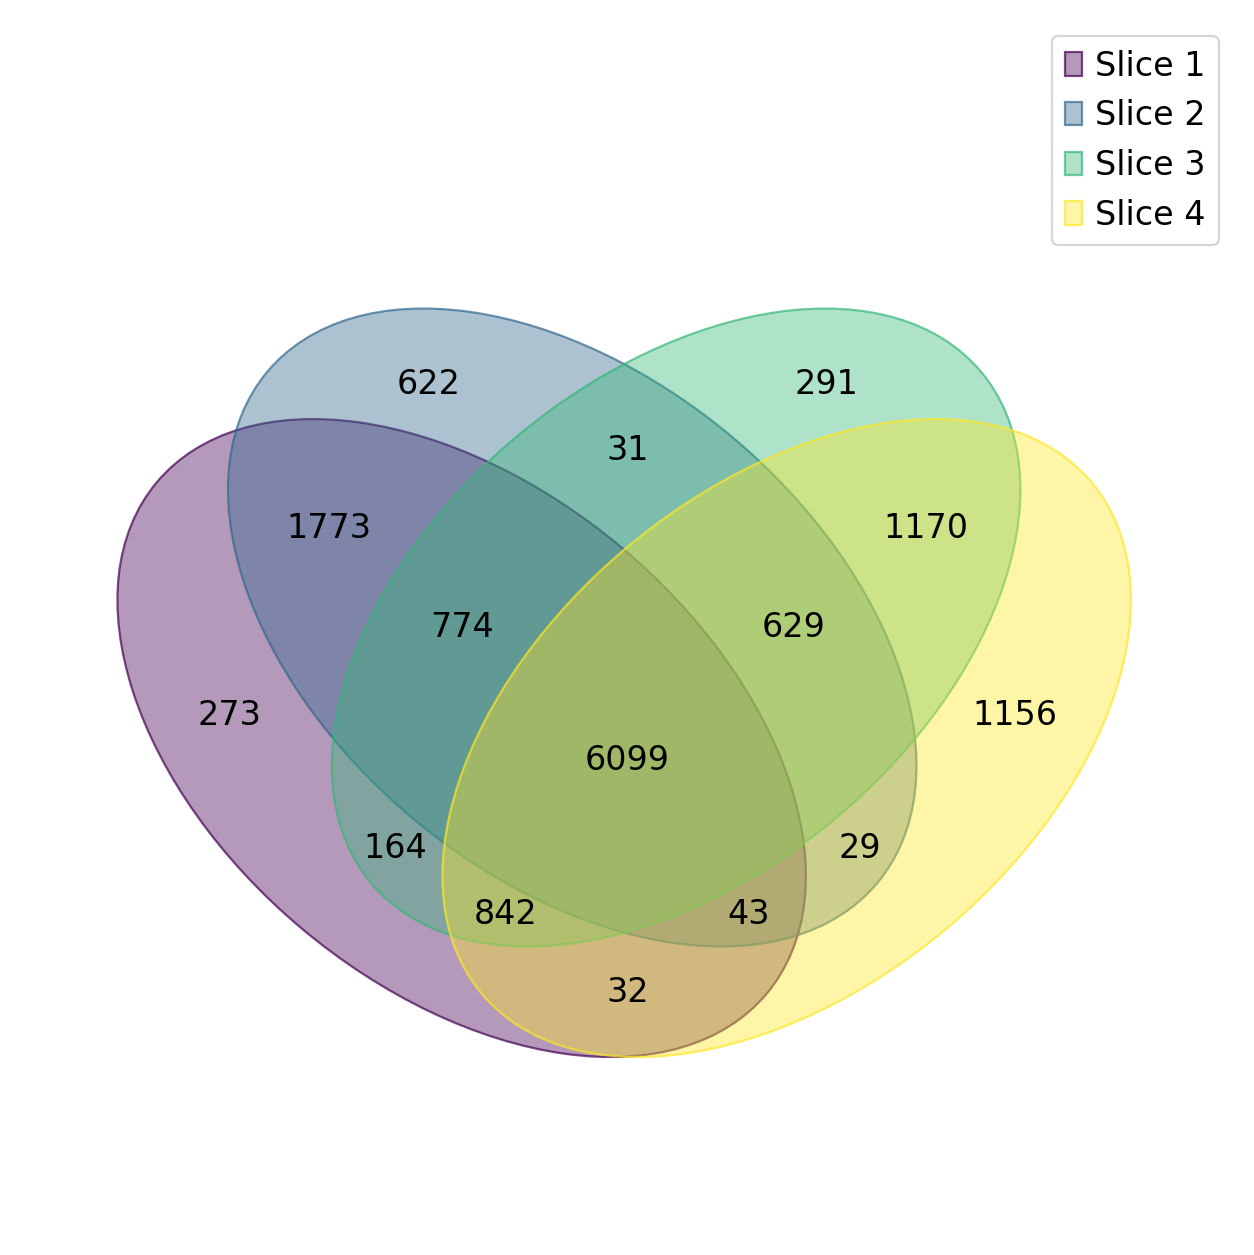

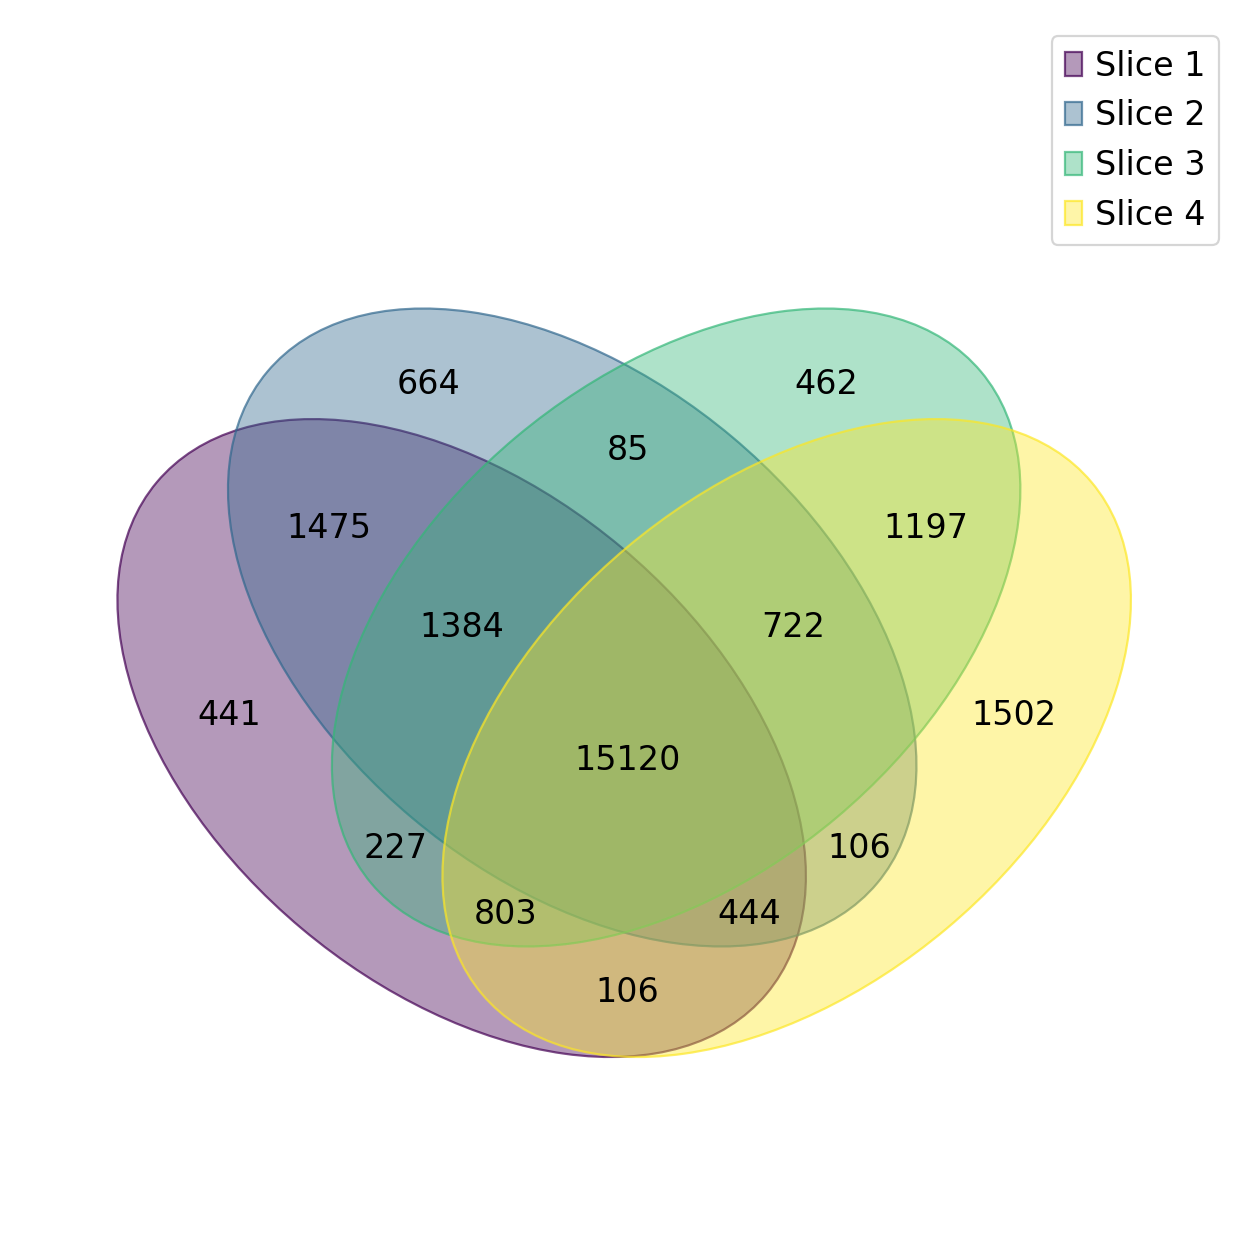

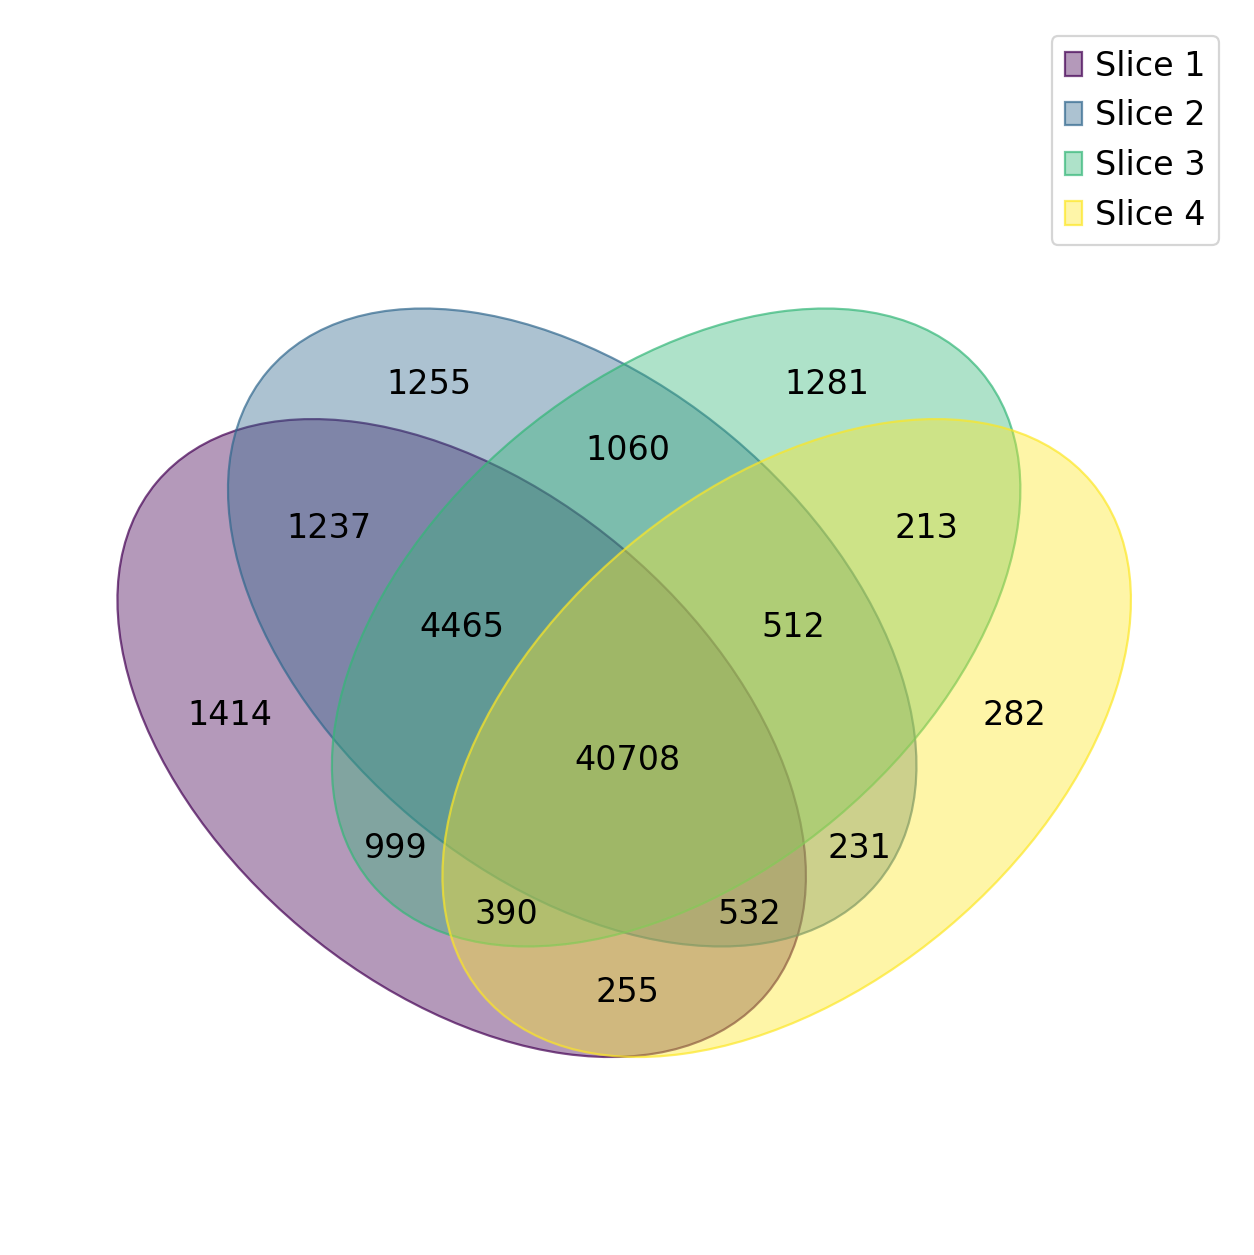

In [91]:
for top in tops:
    print(list(map(lambda x: len([i for i in exps[x]['sorted_scaled_mean'][:top] if i.startswith('hg19_')])/len(exps[x]['sorted_scaled_mean'][:top]), exps.keys())))
    genes_detected_dict = dict(zip(map(lambda x: exps[x]['label'], exps.keys()),map(lambda x: set(exps[x]['sorted_scaled_mean'][:top]), exps.keys())))
    venn(genes_detected_dict, figsize=(10,10), fontsize=15);
    plt.savefig('/data/xyzeq/xyzeq/figures/xyzeq.%dvenn.svg' % top)

In [21]:
labels = get_labels(genes_detected_dict.values(), fill=["percent"])

/home/ghartoularos/anaconda3/envs/xyzeq/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"


In [22]:
labels

{'0001': '(0.2%)',
 '0010': '(0.8%)',
 '0011': '(0.1%)',
 '0100': '(3.2%)',
 '0101': '(0.3%)',
 '0110': '(1.4%)',
 '0111': '(0.4%)',
 '1000': '(2.1%)',
 '1001': '(0.2%)',
 '1010': '(0.8%)',
 '1011': '(0.2%)',
 '1100': '(5.2%)',
 '1101': '(1.6%)',
 '1110': '(10.7%)',
 '1111': '(72.9%)'}